In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [14]:
# 1. 数据加载（我数据集采用的是cicids 2017，然后我用的是里面的
# Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv）

data = pd.read_csv("../dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")

# 查看数据的基本信息
print("数据集基本信息：")
print(data.info())
print("\n数据集前5行：")
print(data.head())

# 2. 数据清洗
# 处理缺失值
print("\n缺失值统计：")
print(data.isnull().sum())

# 删除包含缺失值的行
data = data.dropna()

# 检查重复值
print("\n重复值数量：", data.duplicated().sum())

# 删除重复值
data = data.drop_duplicates()

# 3. 特征编码
# 查看分类特征（非数值特征）
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
print("\n分类特征：", categorical_features)



数据集基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286467 entries, 0 to 286466
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             286467 non-null  int64  
 1    Flow Duration                286467 non-null  int64  
 2    Total Fwd Packets            286467 non-null  int64  
 3    Total Backward Packets       286467 non-null  int64  
 4   Total Length of Fwd Packets   286467 non-null  int64  
 5    Total Length of Bwd Packets  286467 non-null  int64  
 6    Fwd Packet Length Max        286467 non-null  int64  
 7    Fwd Packet Length Min        286467 non-null  int64  
 8    Fwd Packet Length Mean       286467 non-null  float64
 9    Fwd Packet Length Std        286467 non-null  float64
 10  Bwd Packet Length Max         286467 non-null  int64  
 11   Bwd Packet Length Min        286467 non-null  int64  
 12   Bwd Packet Length Mean       28646

In [15]:
# 定义数值特征和分类特征（数据标准化处理的开始）
numeric_features = [
    'Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max',
    'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std',
    'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
    'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean',
    'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean',
    'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
    'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
    'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
    'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
    'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
    'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
    'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size',
    'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1',
    'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
    'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
    'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets',
    'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
    'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std',
    'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'
]

# 使用One-Hot编码对分类特征进行编码
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'  # 保留数值特征
)

# 4. 异常值检测与处理
# 移除无穷大值和非常大的值
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# 5. 应用预处理
X = data.drop(' Label', axis=1)  # 特征
y = data[' Label']              # 标签

# 定义数值特征变换器
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 更新预处理器
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


In [16]:
# 定义预处理管道
numeric_features = X.columns.tolist()  # 使用所有数值列
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [17]:
# 转换数据（数据标准化处理结束）
X_processed = pipeline.fit_transform(X)

# 将处理后的数据转换为 DataFrame
processed_features = pipeline.named_steps['preprocessor'].get_feature_names_out().tolist()
X_processed_df = pd.DataFrame(X_processed, columns=processed_features)

# 合并标签，导出处理后的数据，名字是../result/DataResult_A.csv
processed_data = pd.concat([X_processed_df, y], axis=1)
processed_data.to_csv(r'../result/DataResult_A.csv', index=False)

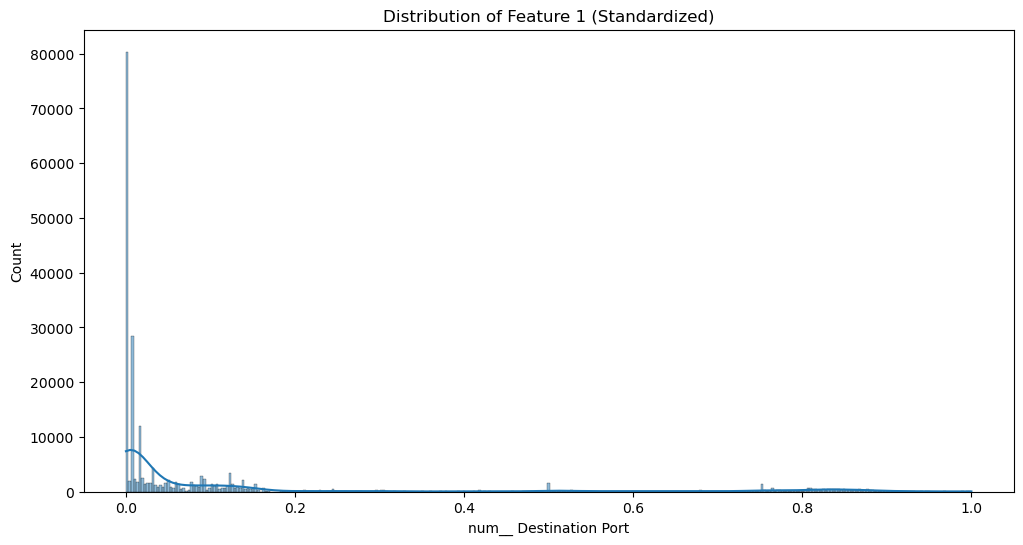

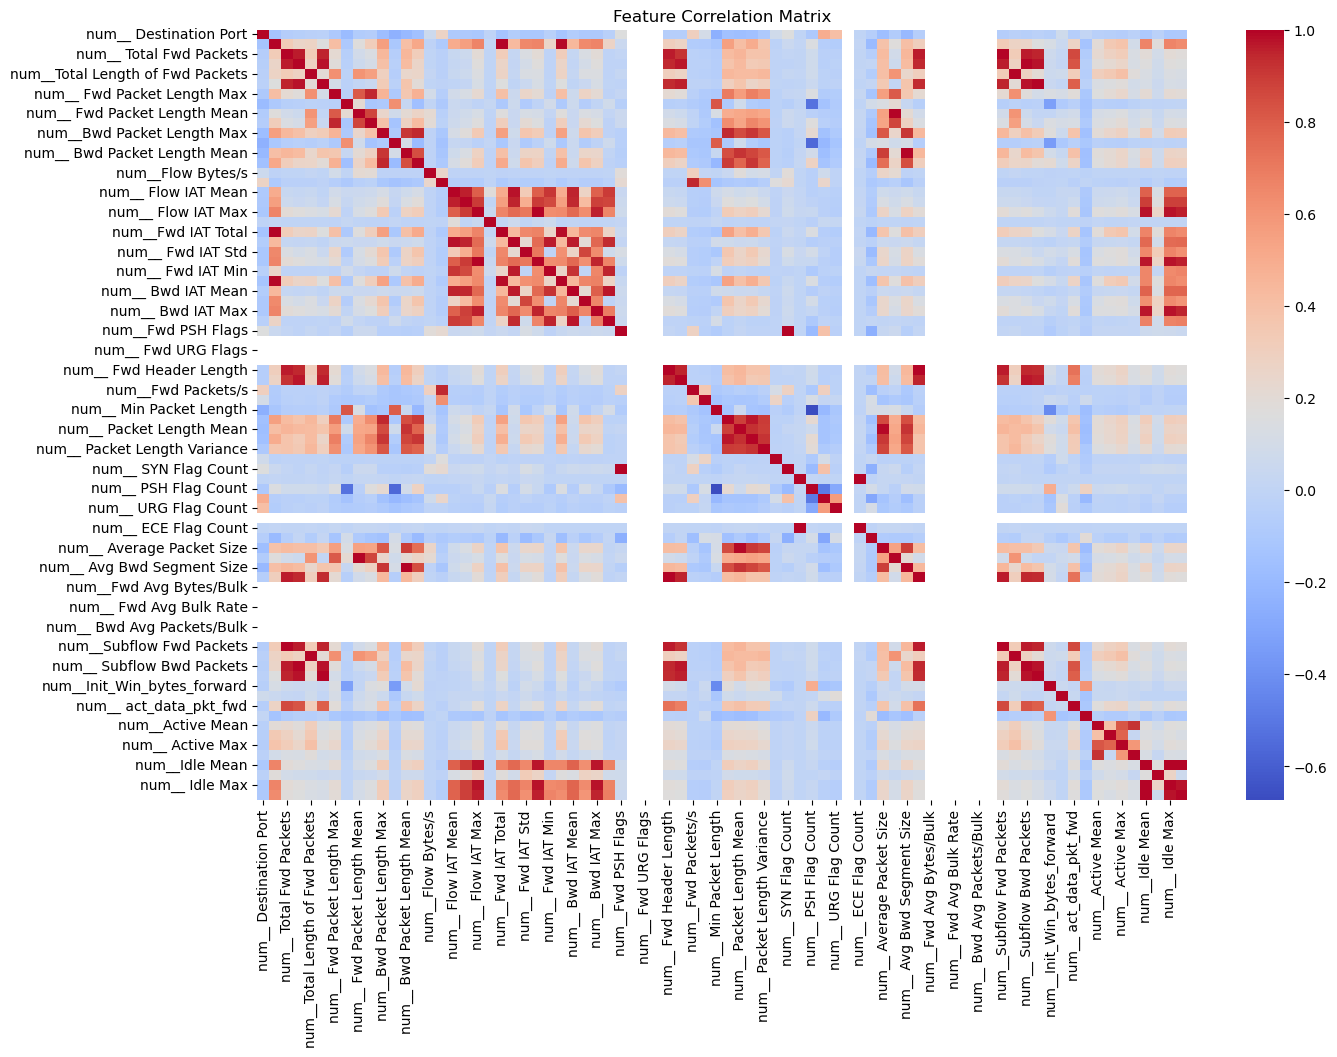

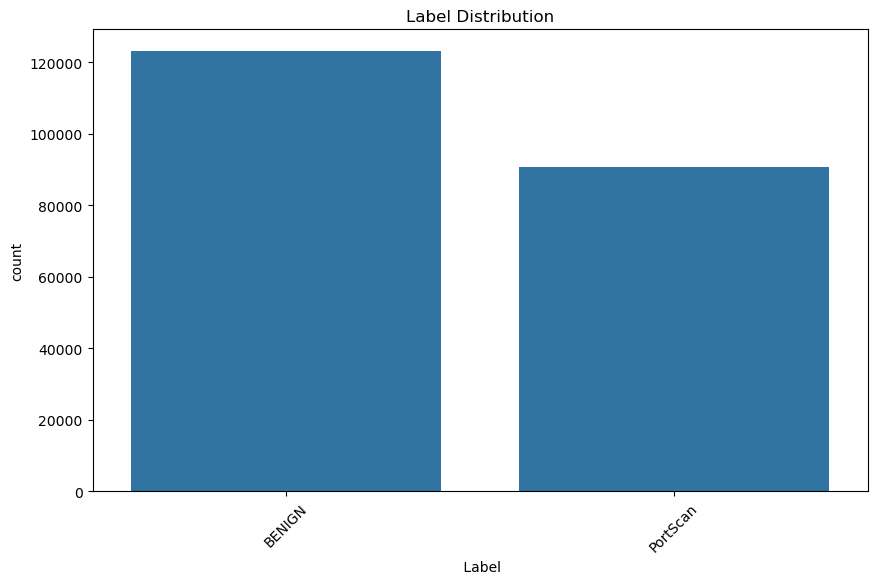

In [18]:
# 数据可视化
# 特征分布
plt.figure(figsize=(12, 6))
sns.histplot(data=X_processed_df.iloc[:, 0], kde=True)
plt.title('Distribution of Feature 1 (Standardized)')
plt.show()

# 特征相关性
plt.figure(figsize=(15, 10))
corr_matrix = X_processed_df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# 标签分布
plt.figure(figsize=(10, 6))
sns.countplot(x=y)
plt.title('Label Distribution')
plt.xticks(rotation=45)
plt.show()